# Week 4 Stats Assignment

In [1]:
import numpy as np
import scipy.stats
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font',size=16)

## Question 1

In [2]:
currents = np.linspace(10, 90, 9) # microamps
voltages = np.array([0.98, 1.98, 2.98, 3.97, 4.95, 5.95, 6.93, 7.93, 8.91]) # millivolts
errors = np.full_like(voltages, 0.01) # millivolts

*i) Calculate the unweighted best-fit gradient and intercept, and their uncertainties.*

In [3]:
sum_xs = sum(currents)
sum_ys = sum(voltages)
sum_xys = sum(voltages * currents)
sum_xs_sq = sum(currents**2)
N = len(currents)

delta = N * sum_xs_sq - sum_xs**2

m = (N * sum_xys - sum_xs * sum_ys) / delta
c = (sum_xs_sq * sum_ys - sum_xs * sum_xys) / delta

residuals = (voltages - (m * currents + c))

alpha_cu = np.sqrt(sum(residuals**2) / (N - 2))
alpha_m = alpha_cu * np.sqrt(N / delta)
alpha_c = alpha_cu * np.sqrt(sum_xs_sq / delta)

print('''Best fit parameters:
     gradient is ({:.5g} +- {:.5f}) mV/muA
    intercept is (  {:.3f} +- {:.1g}) mV'''.format(m, alpha_m, c, alpha_c))

Best fit parameters:
     gradient is (0.099083 +- 0.00009) mV/muA
    intercept is (  -0.001 +- 0.005) mV


*ii) Calculate the common uncertainty, $\alpha_\mathrm{CU}$, and compare the value with the experimental uncertainty.*

In [4]:
print('Common uncertainty alpha_CU is: {:.1g} mV'.format(alpha_cu))

Common uncertainty alpha_CU is: 0.007 mV


This is similar in magnitude to the reported experimental uncertainty.

*iii) Plot a graph of the data and add the best-fit straight line.*

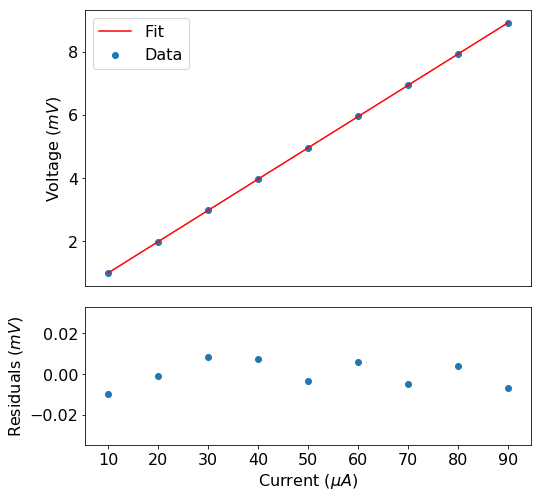

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,8),
                               gridspec_kw={'height_ratios':[2, 1],
                                            'hspace':0.1})
ax1.xaxis.set_visible(False)
ax1.set_ylabel(r'Voltage ($mV$)')
ax1.scatter(currents, voltages, label='Data')
ax1.plot(currents, m * currents + c, 'r', label='Fit')
ax1.legend()

ax2.set_ylabel(r'Residuals ($mV$)')
ax2.set_xlabel(r'Current ($\mu A$)')
ax2.scatter(currents, residuals);

*iv) Calculate the residuals, and comment on their magnitudes.*

In [6]:
# Residuals were calculated in part i)
print('Residuals (mV) are:\n\t',('{:.1g} ' * N).format(*residuals))

Residuals (mV) are:
	 -0.01 -0.0008 0.008 0.008 -0.003 0.006 -0.005 0.004 -0.007 


These values all lie within the variation expected from the reported experimental uncertainties.

## Question 2

In [7]:
intervals = np.array([(-np.inf, -2.5), (-2.5, -2), (-2, -1.5), (-1.5, -1),
                      (-1, -0.5), (-0.5, 0), (0, 0.5), (0.5, 1), (1, 1.5),
                      (1.5, 2), (2, 2.5), (2.5, np.inf)], dtype='f')

n_observed = np.array([9, 48, 142, 154, 438, 521,
                       405, 318, 299, 100, 57, 9], dtype='f')

n_bins = len(n_observed)
n_total = sum(n_observed)

*i) Use Eq 3.9 to determine the number of expected data points in each interval, $E_i$.*

Expected distribution of counts is: 
	[-inf -2.5] : 15.524163314440331
	[-2.5 -2. ] : 41.351166556007655
	[-2.  -1.5] : 110.14267330169719
	[-1.5 -1. ] : 229.6201316564975
	[-1.  -0.5] : 374.7057119863245
	[-0.5  0. ] : 478.6561531850328
	[ 0.   0.5] : 478.6561531850328
	[ 0.5  1. ] : 374.7057119863245
	[ 1.   1.5] : 229.62013165649748
	[ 1.5  2. ] : 110.14267330169719
	[ 2.   2.5] : 41.35116655600763
	[ 2.5  inf] : 15.524163314440397


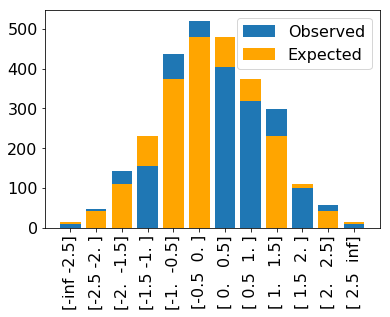

In [8]:
n_expected = (scipy.stats.norm.cdf(intervals[:,1])
              - scipy.stats.norm.cdf(intervals[:,0])) * n_total
    
print('Expected distribution of counts is:',('\n\t{} : {}' * n_bins)
      .format(*itertools.chain(*zip(intervals, n_expected))))

xs = np.arange(n_bins)

mask1 = np.ma.where(n_observed >= n_expected)
mask2 = np.ma.where(n_observed <= n_expected)

plt.figure()
ax = plt.gca()
ax.bar(xs[mask1], n_observed[mask1], label='Observed')
ax.bar(xs, n_expected, color='orange', label='Expected')
ax.bar(xs[mask2], n_observed[mask2], color='tab:blue')
ax.set_xticks(xs)
ax.set_xticklabels(intervals)
for t in ax.get_xticklabels():
    t.set_rotation(90)
ax.legend();

*ii) Show that $E_i>5$ for all bins.*

In [9]:
print((n_expected > 5).all())

True


*iii) Calculate $\chi^2$.*

In [10]:
chi_sq = sum((n_observed - n_expected)**2 / n_expected)
print('chi^2 is: {:.3g}'.format(chi_sq))

chi^2 is: 103


*iv) Calculate the number of degrees of freedom.*

DoF $\nu=N-\mathcal{N}$ where $N$ is number of observations and $\mathcal{N}$ is number of parameters in the fit.

Here $N=12$ and $\mathcal{N}=2$: for a Gaussian fit the free parameters are the mean and standard deviation.

Hence $\nu=10$.

*v) Are the data consistent with the hypothesis of a Gaussian distribution?*

In [11]:
nu = 10

reduced_chi_sq = chi_sq / nu
print('chi^2/nu is: {:.3g}'.format(reduced_chi_sq))

chi^2/nu is: 10.3


The value of $\chi^2/\nu$ is much greater than 1, which implies that a normal distribution is not a good fit for this data.

## Question 3

In [12]:
# Benford's Law
def benford(a):
    return np.log10(1 + 1 / a)

*i) Use Benford's Law to calculate the probability of obtaining a first digit $a$, for $1\leq a \leq 9$.*

In [13]:
digits = np.linspace(1, 9, 9)

probs = benford(digits)

print('''Probabilities of obtaining a first digit A are:
    A prob''', ('\n    {:.0f} {:.3g}' * 9).format(*itertools.chain(*zip(digits, probs))))

# probabilities should sum to 1
sum_is_1 = np.isclose(sum(probs), 1.0)
print('Do probabilities sum to 1?:', ('yes' if sum_is_1 else 'no'))

Probabilities of obtaining a first digit A are:
    A prob 
    1 0.301
    2 0.176
    3 0.125
    4 0.0969
    5 0.0792
    6 0.0669
    7 0.058
    8 0.0512
    9 0.0458
Do probabilities sum to 1?: yes


*ii) Using Benford's formula and the total count for that group, calculate the expected number of occurences of the first digit being $a$, $E_a$, for $1\leq a \leq 9$.*

I chose to analyse the 'Population' dataset.

The expected values according to Benford's law are found by multiplying the probabilities above by the number of observations made, which is 3259 for this dataset.

In [14]:
percentages = np.array([33.9, 20.4, 14.2, 8.1, 7.2, 6.2, 4.1, 3.7, 2.2])

total =  3259

expected = probs * total
print('Expected occurences of a first digit A are:\n    A E_a',
      ('\n    {:.0f} {:.0f}' * 9).format(*itertools.chain(*zip(digits,expected))))

Expected occurences of a first digit A are:
    A E_a 
    1 981
    2 574
    3 407
    4 316
    5 258
    6 218
    7 189
    8 167
    9 149


*iii) Ascertain whether some of the bins should be combined.*

Bins should be combined if fewer than 5 values are expected in that bin, to avoid the asymmetry of the Poisson distribution at low mean values.

In [15]:
print(' There are {} bins with fewer than 5 values.'.format(
    len(expected[expected < 5])))

 There are 0 bins with fewer than 5 values.


Hence no bins require combining.

*iv) From the table, and the total count for that group, calculate the observed number of occurences of the first digit being a, $O_a$, for $1\leq a \leq 9$.*

In [16]:
observed = (percentages / 100) * total
print('Observed occurences of a first digit A are:\n    A O_a',
      ('\n    {:.0f} {:.0f}' * 9).format(*itertools.chain(*zip(digits,observed))))

Observed occurences of a first digit A are:
    A O_a 
    1 1105
    2 665
    3 463
    4 264
    5 235
    6 202
    7 134
    8 121
    9 72


*v) Calculate $\chi^2$ and the number of degrees of freedom.*

$$\chi^2=\sum\frac{(O_i-E_i)^2}{E_i}$$

DoF $\nu = N - \mathcal{N}$, where $N=9$ and $\mathcal{N}=2$. The two constraints are:

- The mean of the sample and parent distributions are the same.
- The two distributions contain the same number of measurements.

In [17]:
residuals = (observed - expected) / np.sqrt(expected)

chi_sq = sum(residuals**2)
print('chi^2 is: {:.3g}'.format(chi_sq))

chi^2 is: 119


*vi) Test the hypothesis that the distribution for that group follows Benford's Law.*

The reduced chi^2 is:
    16.9
Probability of obtaining this result from the chi^2 distribution is:
    0


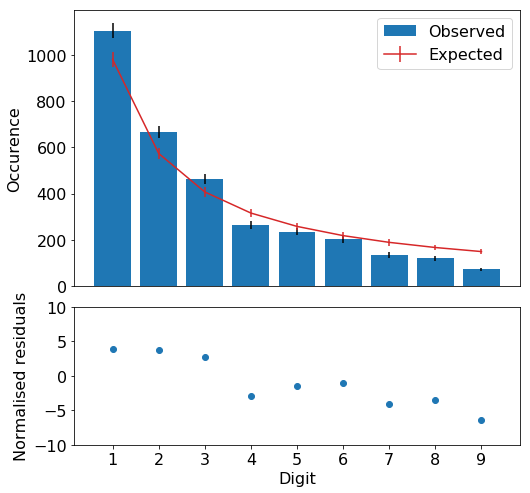

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,8),
                               gridspec_kw={'height_ratios':[2, 1],
                                            'hspace':0.1})
ax1.xaxis.set_visible(False)
ax1.set_ylabel('Occurence')
ax1.bar(digits, observed, yerr=np.sqrt(observed), label='Observed')
ax1.errorbar(digits, expected, np.sqrt(expected), c='tab:red', label='Expected')
ax1.legend()

ax2.set_ylim(-10, 10)
ax2.set_ylabel(r'Normalised residuals')
ax2.set_xlabel(r'Digit')
ax2.xaxis.set_ticks(digits)
ax2.scatter(digits, residuals);

red_chi_sq = chi_sq / 7
print('The reduced chi^2 is:\n    {:.3g}'.format(red_chi_sq))

chi_sq_prob = 1 - scipy.stats.chi2.cdf(chi_sq, 7)
print('Probability of obtaining this result from the chi^2 distribution is:\n    {:.3g}'
      .format(chi_sq_prob))

The above results indicate that it is highly unlikely that Benford's law provides an accurate fit to these data.

## Question 4

In [19]:
data = np.loadtxt('BevingtonData.csv', skiprows=1,
                 dtype=[('time','f'), ('counts', 'f')])

# add errors to the data
from numpy.lib.recfunctions import append_fields
data = append_fields(data, 'errors', np.sqrt(data['counts']) / 15, 'f')
# normalise to counts per second
data['counts'] = data['counts'] / 15

To fit the data, need to perform a $\chi^2$ minimisation.

The fitting function is: $y=a_1+a_2\mathrm{e}^{-t/a_4}+a_3\mathrm{e}^{-t/a_5}$. Also need the gradient vector $dy$.

From these can calculate $\chi^2$ and $d\chi^2$.

In [20]:
def y(t, a1, a2, a3, a4, a5):
    return a1 + a2 * np.exp(-t / a4) + a3 * np.exp(-t / a5)

def dy(t, a1, a2, a3, a4, a5):
    dyda1 = np.ones_like(t)
    dyda2 = np.exp(-t / a4)
    dyda3 = np.exp(-t / a5)
    dyda4 = (a2 * t / a4**2) * np.exp(-t / a4)
    dyda5 = (a3 * t / a5**2) * np.exp(-t / a5)
    return np.array([dyda1, dyda2, dyda3, dyda4, dyda5]).T

To perform the minimisation, the `scipy.optimize` library is used.

In [21]:
import scipy.optimize as optimize

x, cov = optimize.curve_fit(y, data['time'], data['counts'],
                            jac=dy, sigma=data['errors'],
                            bounds=([0]*5,[1000]*5))
fit_errs = np.sqrt(cov.diagonal())

print('''Best-fit parameters are:
    a1 = {:.2f} +- {:.2g}
    a2 = {:.1f} +- {:.2g}
    a3 = {:.2g} +- {:.1g}
    a4 = ({:.2g} +- {:.1g}) s
    a5 = ({:.2g} +- {:.1g}) s
    '''.format(*itertools.chain(*zip(x, fit_errs))))

Best-fit parameters are:
    a1 = 0.68 +- 0.14
    a2 = 8.6 +- 1.6
    a3 = 64 +- 4
    a4 = (2.1e+02 +- 4e+01) s
    a5 = (34 +- 3) s
    


These values and errors seem reasonable, so next I calculate $\chi^2$ and the residuals.

Percentage of normalised residuals within 1 SD of mean is: 61.0%
chi^2 is: 66.1
reduced chi^2 is: 1.1


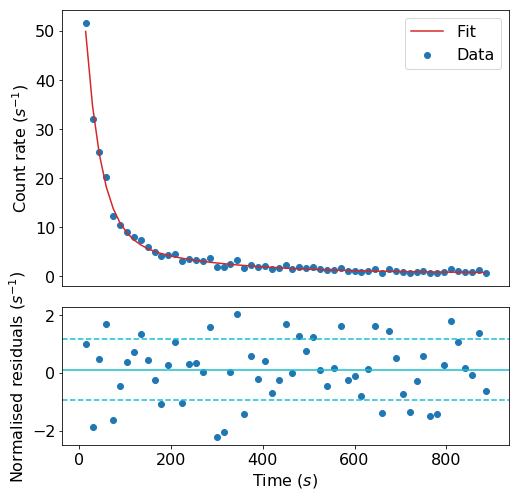

In [22]:
normed_residuals = (data['counts'] - y(data['time'], *x)) / data['errors']
resid_mean = np.mean(normed_residuals)
resid_sd = np.std(normed_residuals)

resid_frac = len(normed_residuals[abs(normed_residuals - resid_mean) < resid_sd])/ len(normed_residuals)
print('Percentage of normalised residuals within 1 SD of mean is: {:.1%}'.format(resid_frac))

chi2 = sum(normed_residuals**2)
print('chi^2 is: {:.1f}'.format(chi2))

nu = len(data['counts'] - 5) # five dependent parameters in fit
red_chi2 = chi2 / nu
print('reduced chi^2 is: {:.1f}'.format(red_chi2))

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,8),
                               gridspec_kw={'height_ratios':[2, 1],
                                            'hspace':0.1})
ax1.xaxis.set_visible(False)
ax1.set_ylabel(r'Count rate ($s^{-1}$)')
ax1.scatter(data['time'], data['counts'], label='Data')
ax1.plot(data['time'], y(data['time'], *x), 'tab:red', label='Fit')
ax1.legend()

ax2.set_ylabel(r'Normalised residuals ($s^{-1}$)')
ax2.set_xlabel(r'Time ($s$)')
ax2.axhline(resid_mean, c='tab:cyan')
ax2.axhline(resid_mean + resid_sd, linestyle='--', c='tab:cyan')
ax2.axhline(resid_mean - resid_sd, linestyle='--', c='tab:cyan')
ax2.scatter(data['time'], normed_residuals);

The reduced $\chi^2$ of 1.1 suggests that the data is well-fitted by the given function, as does the fact that the percentage of normalised residuals within one standard deviation of the mean is close to the expected 65%.

Next, analyse the residuals using a lag plot and calculating the Durbin-Watson statistic.

Durbin-Watson statistic is: 2.14
Percentage of lag plot points within 2 SD of mean: 94.8%


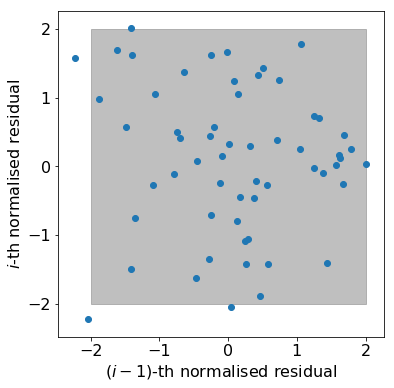

In [23]:
dw = sum([(normed_residuals[i] - normed_residuals[i - 1])**2
          for i in range (1, len(normed_residuals))]) / sum(normed_residuals**2)
print('Durbin-Watson statistic is: {:.3g}'.format(dw))

lagplot = np.column_stack([normed_residuals[1:], [normed_residuals[i - 1]for i in range(1, len(normed_residuals))]])

lp_meanx, lp_meany = np.mean(lagplot[:,0]), np.mean(lagplot[:,1])
lp_sdx, lp_sdy = np.std(lagplot[:,0]), np.std(lagplot[:,1])
two_sigma_frac = len(lagplot[(abs(lagplot[:,0] - lp_meanx) < 2 * lp_sdx) &
                             (abs(lagplot[:,1] - lp_meany) < 2 * lp_sdy)]) / len(lagplot)
print('Percentage of lag plot points within 2 SD of mean: {:.1%}'.format(two_sigma_frac))

plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_aspect('equal')
ax.set_ylabel('$i$-th normalised residual')
ax.set_xlabel('$(i-1)$-th normalised residual')
ax.fill_between([-2, 2], -2, 2, alpha=0.5, color='gray')
plt.scatter(lagplot[:,0], lagplot[:,1]);

The Durbin-Watson statistic is close to 2, and the percentage of points on the lag plot that lie within a 2-$\sigma$ range of the mean is very close to the expected value of 95%. This provides further evidence that the data is well-fitted by the given function.